#### In this notebook we will be automating the entire process that we did in the data modeling notebook. We will be writing the code in Object Oriented Paradigm. The 3 algorithms that we tested our data in the data modeling phase was:
 - Linear Regression
 - Random Forest Regressor
 - Gradient Boosting Resgressor
#### We will later automate the pipleine and also deploy the solutions after selecting the model that performs better than the other two.

In [1]:
# importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [2]:
#The idea of object oriented code used in this notebook is adapted from Data Science Dream Job course case study

In [3]:
# Function to read the csv file and store it into the dataframe
def read_csv(file):
    return pd.read_csv(file)

In [4]:
# Function to clean the data. This is the same function that we used in data modeling noteobook
def clean_df(raw_df):
    # Dropping jobId column if they are duplicates and selecting only those salaries that are greater than zero
    
    clean_df = raw_df.drop_duplicates(subset='jobId')
    clean_df = clean_df[clean_df.salary>0]
    return clean_df

# Function to perform inner join two dataframe based on any features 

def consolidate_data(df1, df2, key=None, left_index=False, right_index=False):
    # Perfroming inner join based on the key passed in the data frame
    
    return pd.merge(left=df1, right=df2, how='inner', on=key, left_index=left_index, right_index=right_index)

In [5]:
# Function to perform one hot encoding on the dataframe
def one_hot_encode_df(df, cat_vars=None, num_vars=None):
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)

In [6]:
# Function to return the target dataframe
def get_target_df(df, target):
    return df[target]

In [7]:
# Function to train the models that we specified above
def train_models(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

In [8]:
# Function to print the summary of model
def print_summary_models(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

In [9]:
# Function to save the results(predictions) and also to plot the feature importance into the model
def save_results(model, mean_mse, predictions, feature_importances):
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')

In [10]:
# Definining train data
train_feature_file = 'data/train_features.csv'
train_target_file = 'data/train_salaries.csv'
test_feature_file = 'data/test_features.csv'

In [11]:
# Defining  catergorical, numerical and target variables
categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
numeric_vars = ['yearsExperience', 'milesFromMetropolis']
target_var = 'salary'

In [12]:
# Loading the train data
print("Reading data")
feature_df = read_csv(train_feature_file)
target_df = read_csv(train_target_file)
test_df = read_csv(test_feature_file)

# Merging the train data and target data
train_df = consolidate_data(feature_df, target_df, key='jobId')

# Cleaning the data
clean_train_df = shuffle(clean_df(train_df)).reset_index()

# Performing one hot encoding on the training data
print("Encoding data")
feature_df = one_hot_encode_df(clean_train_df, cat_vars=categorical_vars, num_vars=numeric_vars)
test_df = one_hot_encode_df(test_df, cat_vars=categorical_vars, num_vars=numeric_vars)

# Get target df
target_df = get_target_df(clean_train_df, target_var)

Reading data
Encoding data


In [13]:
# Initializing model list and disctionaris for mean mas enad cross validation standard deviation
models = []
mean_mse = {}
cv_std = {}
res = {}

# Define number of processes to run in parallel
num_procs = 2

# Define shared model paremeter
verbose_lvl = 0

#### We already did hyperperameter tuning of each model in Data Modeling notebook. So we will simply create model objects and train them.
 - We will store the mean_mse in dictionary
 - We will perform cross-validation using k-fold cross validation 
 - We will store the result in dictionary

In [14]:
# Create model objects

lr = LinearRegression()
lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
rf = RandomForestRegressor(n_estimators=150, n_jobs=num_procs, max_depth=25, min_samples_split=60,\
                           max_features=30, verbose=verbose_lvl)
gbm = GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls', verbose=verbose_lvl)


models.extend([lr, lr_std_pca, rf, gbm])

In [15]:
#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_models(model, feature_df, target_df, num_procs, mean_mse, cv_std)
    print_summary_models(model, mean_mse, cv_std)

Beginning cross validation

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.4697353769307
Standard deviation during CV:
 0.1222596564957712

Model:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Average MSE:
 384.4582452743912
Standard deviation during CV:
 0.10643763257897376

Model:
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features=30, max_leaf_nodes=None,
                      max_

In [16]:
# choosing model with lowest mse and deploying it on the whole data
model = min(mean_mse, key=mean_mse.get)
print('\nThe model with lowest MSE is:')
print(model)


The model with lowest MSE is:
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [17]:
#train model with entire dataset
model.fit(feature_df, target_df)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
#create predictions based on test dataset
predictions = model.predict(test_df)

In [33]:
# Plotting and storing feature importanceortance attribute
# linear model does not have feature_imp
if hasattr(model,'feature_importances_'):
    importances = model.feature_importances_
else:
    importances = [0]*len(feature_df.columns)

In [34]:
#creating feature_importances datframe and saving the model results to csv
feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [35]:
feature_importances.set_index('feature', inplace=True, drop=True)
save_results(model, mean_mse[model], predictions, feature_importances)

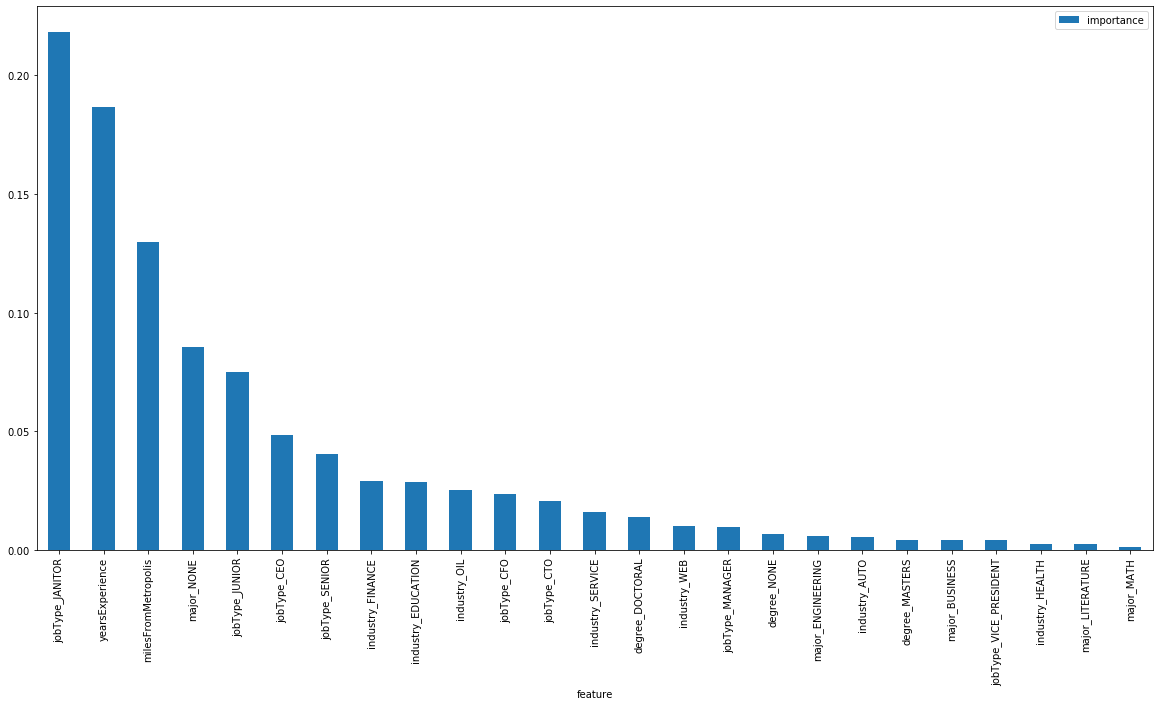

In [36]:
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()